# Credit Card Fraud Detection - Modeling

## Table of Contents
1. <a href="#1-import">Import</a>
2. <a href="#2-implement-evaluation-metrics">Implement Evaluation Metrics</a>
3. <a href="#3-model-logistic-regression">Model: Logistic Regression</a>
    - 3.1. <a href="#31-introduction-to-logistic-regression">Introduction to Logistic Regression</a>
    - 3.2. <a href="#32-class-setting">Class Setting</a>
    - 3.3. <a href="#33-training-analysis">Training Analysis</a>
    - 3.4. <a href="#34-test-and-evaluate">Test and Evaluate</a>
        - 3.4.1. <a href="#341-quantitative-metrics-analysis">Quantitative Metrics Analysis</a>
        - 3.4.2. <a href="#342-confusion-matrix-analysis">Confusion Matrix Analysis</a>
        - 3.4.3. <a href="#343-roc-curve-and-auc-analysis">ROC Curve and AUC Analysis</a>

## 1. Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)

## 2. Implement Evaluation Metrics

Trong bài toán phát hiện gian lận (dữ liệu mất cân bằng), độ chính xác (Accuracy) không phải là thước đo tốt. Chúng ta sẽ tập trung vào các chỉ số sau:

* **Precision (Độ chính xác dương tính):** Trong số các giao dịch mô hình dự đoán là gian lận, bao nhiêu phần trăm là đúng? (Tránh làm phiền khách hàng bằng các cảnh báo giả).
* **Recall (Độ nhạy):** Mô hình phát hiện được bao nhiêu phần trăm tổng số vụ gian lận thực tế? (Tránh bỏ lọt tội phạm).
* **F1-Score:** Trung bình điều hòa giữa Precision và Recall.
* **AUPRC (Area Under Precision-Recall Curve):** Chỉ số quan trọng nhất cho dữ liệu mất cân bằng, đo lường khả năng phân loại tốt mà không phụ thuộc vào ngưỡng (threshold).
* **Confusion Matrix:** Cho cái nhìn trực quan về số lượng False Positives và False Negatives.

In [2]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    # Binary classification: 0 = negative, 1 = positive
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    return np.array([[tn, fp], [fn, tp]])

def precision_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def recall_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]
    
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def roc_curve(y_true, y_scores):
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]
    
    thresholds = np.unique(y_scores_sorted)
    thresholds = np.append(thresholds, thresholds[-1] + 1)
    
    fpr = []
    tpr = []
    
    for threshold in thresholds:
        y_pred = (y_scores_sorted >= threshold).astype(int)
        cm = confusion_matrix(y_true_sorted, y_pred)
        
        tn, fp = cm[0, 0], cm[0, 1]
        fn, tp = cm[1, 0], cm[1, 1]
        
        # False Positive Rate
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        # True Positive Rate (Recall)
        tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        fpr.append(fpr_val)
        tpr.append(tpr_val)
    
    return np.array(fpr), np.array(tpr), thresholds

def auc_score(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]
    
    auc = np.trapz(tpr_sorted, fpr_sorted)
    return auc

## 3. Model: Logistic Regression

### 3.1. Giới thiệu thuật toán

**Logistic Regression** là một thuật toán phân loại sử dụng hàm sigmoid để dự đoán xác suất:

$$P(y=1|x) = \frac{1}{1 + e^{-(w^T x + b)}}$$

**Loss function** (Binary Cross-Entropy):
$$L = -\frac{1}{m}\sum_{i=1}^{m}[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$$

**Gradient descent** để cập nhật weights:
$$\frac{\partial L}{\partial w} = \frac{1}{m}X^T(\hat{y} - y)$$
$$\frac{\partial L}{\partial b} = \frac{1}{m}\sum(\hat{y} - y)$$

### 3.2. Class Setting

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6, random_state=None):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _binary_cross_entropy_loss(self, y_true, y_pred):
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        m, n = X.shape
        
        self.weights = np.random.randn(n) * 0.01
        self.bias = 0.0
        
        X_with_bias = np.column_stack([np.ones(m), X])
        weights_with_bias = np.append(self.bias, self.weights)
        
        for i in range(self.max_iter):
            z = X_with_bias @ weights_with_bias
            y_pred = self._sigmoid(z)
            
            loss = self._binary_cross_entropy_loss(y, y_pred)
            self.loss_history.append(loss)
            
            dw = (1/m) * X.T @ (y_pred - y)
            db = (1/m) * np.sum(y_pred - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            weights_with_bias = np.append(self.bias, self.weights)
            
            if i > 0 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tol:
                print(f"Converged at iteration {i+1}")
                break
    
    def predict_proba(self, X):
        m = X.shape[0]
        X_with_bias = np.column_stack([np.ones(m), X])
        weights_with_bias = np.append(self.bias, self.weights)
        
        z = X_with_bias @ weights_with_bias
        probabilities = self._sigmoid(z)
        
        return probabilities
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

### 3.3. Training Analysis

Training completed!
Number of iterations: 1000
Final loss: 0.10950457
Weights shape: (30,)
Bias: -2.169684


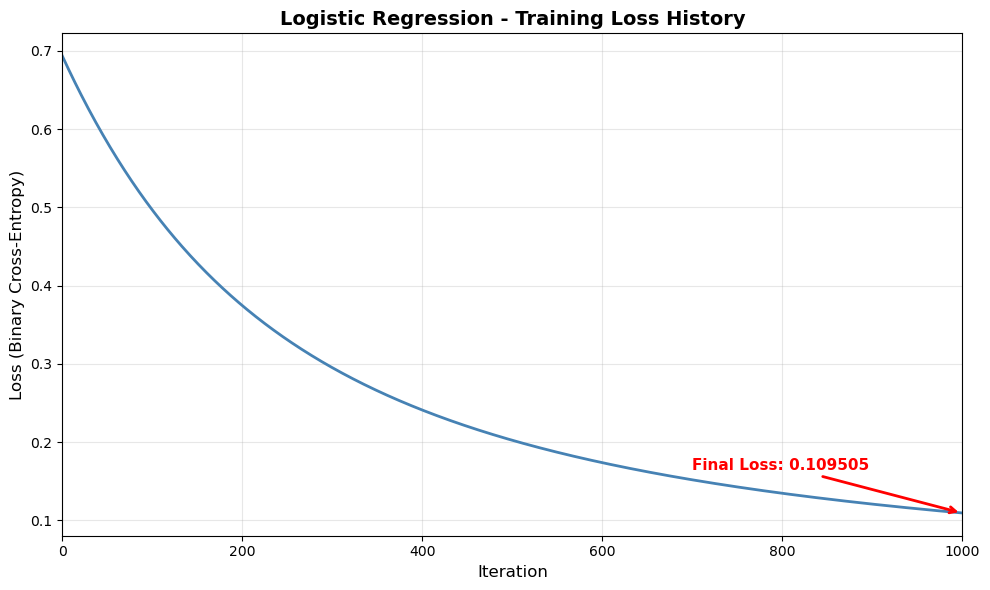

In [4]:
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')
header = np.load('../data/processed/header.npy', allow_pickle=True)

lr_model = LogisticRegression(learning_rate=0.01, max_iter=1000, tol=1e-6, random_state=42)
lr_model.fit(X_train, y_train)

print(f"Training completed!")
print(f"Number of iterations: {len(lr_model.loss_history)}")
print(f"Final loss: {lr_model.loss_history[-1]:.8f}")
print(f"Weights shape: {lr_model.weights.shape}")
print(f"Bias: {lr_model.bias:.6f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lr_model.loss_history, linewidth=2, color='steelblue')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
ax.set_title('Logistic Regression - Training Loss History', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim([0, len(lr_model.loss_history)])

final_loss = lr_model.loss_history[-1]
ax.annotate(f'Final Loss: {final_loss:.6f}', 
           xy=(len(lr_model.loss_history)-1, final_loss),
           xytext=(len(lr_model.loss_history)*0.7, final_loss*1.5),
           arrowprops=dict(arrowstyle='->', color='red', lw=2),
           fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

#### Phân tích quá trình huấn luyện

Dựa vào biểu đồ **Training Loss History** và thông số cuối cùng:
* **Sự hội tụ (Convergence):** Đường Loss giảm đều và mượt mà, tiệm cận về giá trị ~0.1095 sau 1000 vòng lặp. Điều này chứng tỏ thuật toán Gradient Descent hoạt động đúng, Learning Rate `0.01` là phù hợp (không bị dao động quá mạnh hay hội tụ quá chậm).
* **Underfitting/Overfitting:** Mức loss này khá thấp đối với bài toán phân loại nhị phân, cho thấy mô hình đã học được các đặc trưng từ dữ liệu huấn luyện. Tuy nhiên, để khẳng định mô hình có bị Overfitting hay không, chúng ta cần xem xét kết quả trên tập Test ở phần tiếp theo.

### 3.4. Test and Evaluate

#### 3.4.1. Quantitative Metrics Analysis

In [5]:
print("=== Logistic Regression - Prediction ===")
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("\nTest Results:")
print(f"Accuracy:  {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall:    {rec_lr:.4f}")
print(f"F1-Score:  {f1_lr:.4f}")

=== Logistic Regression - Prediction ===

Test Results:
Accuracy:  0.9989
Precision: 0.8333
Recall:    0.4592
F1-Score:  0.5921


Kết quả trên tập Test cho thấy một bức tranh rõ ràng về bài toán mất cân bằng dữ liệu:

1.  **Accuracy (0.9989):** Rất cao, nhưng **vô nghĩa** trong ngữ cảnh này. Vì số lượng giao dịch bình thường chiếm đa số, mô hình chỉ cần dự đoán tất cả là "Bình thường" cũng có thể đạt accuracy > 99%.
2.  **Precision (0.8333):** Khá tốt. Có nghĩa là khi mô hình cảnh báo "Đây là lừa đảo", thì 83.33% khả năng đó đúng là lừa đảo. Điều này giúp giảm thiểu việc làm phiền khách hàng (False Positive thấp).
3.  **Recall (0.4592):** **Đây là vấn đề cần quan tâm.** Chỉ số này cho biết mô hình chỉ phát hiện được khoảng **46%** tổng số vụ gian lận thực tế. Hơn 54% số vụ gian lận đã bị bỏ lọt (False Negative cao).
4.  **F1-Score (0.5921):** Phản ánh sự đánh đổi giữa Precision và Recall. Mức điểm này ở mức trung bình, bị kéo xuống do Recall thấp.

**Nhận định:** Với Logistic Regression cơ bản và ngưỡng (threshold) mặc định là 0.5, mô hình đang an toàn quá mức (thiên về Precision) và bỏ sót nhiều tội phạm (Recall thấp).

#### 3.4.2. Confusion Matrix Analysis

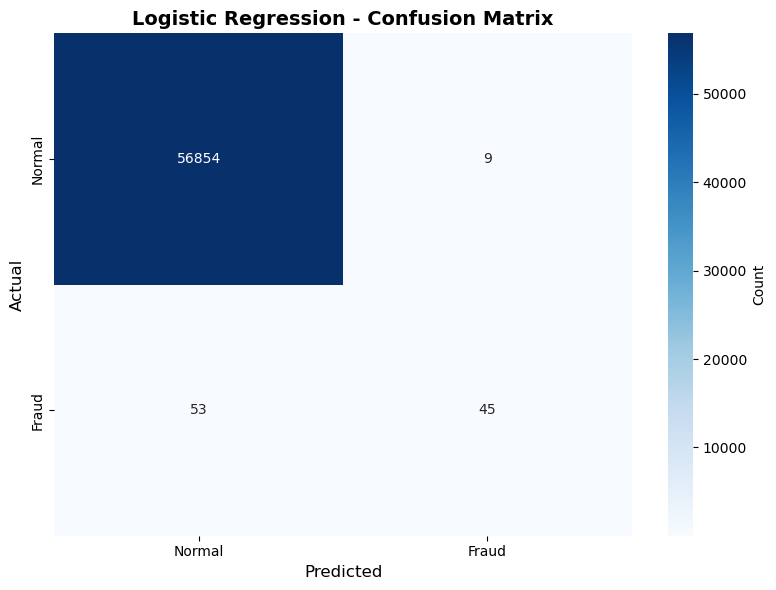

In [6]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Normal', 'Fraud'],
           yticklabels=['Normal', 'Fraud'],
           ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Biểu đồ nhiệt (Heatmap) làm rõ hơn các con số ở trên:
* **True Negatives (Góc trên trái):** Đa số các giao dịch bình thường được phân loại đúng.
* **False Positives (Góc trên phải):** Số lượng báo động giả thấp (tương ứng với Precision cao).
    * Ý nghĩa: Chỉ có 9 khách hàng bị làm phiền hoặc bị khóa thẻ oan. Con số này rất thấp, cho thấy mô hình có Precision (Độ chính xác) cao.
* **False Negatives (Góc dưới trái):** Số lượng giao dịch gian lận bị bỏ sót (mô hình dự đoán là 0 nhưng thực tế là 1). Đây là con số chúng ta muốn giảm thiểu nhất trong bài toán ngân hàng.
    * Ý nghĩa: Đây là con số nguy hiểm nhất trong bài toán này. Mô hình đã bỏ sót 53 vụ gian lận, gây thất thoát tài chính trực tiếp cho ngân hàng/công ty.
* **True Positives (Góc dưới phải):** Số lượng gian lận bắt được.

#### 3.4.3. ROC Curve and AUC Analysis

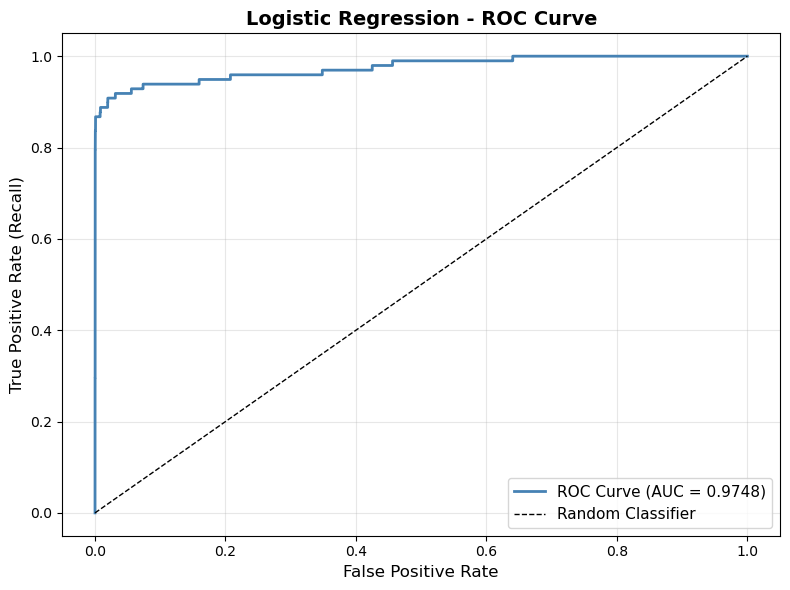


AUC Score: 0.9748


In [7]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
auc_lr = auc_score(fpr_lr, tpr_lr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_lr, tpr_lr, linewidth=2, label=f'ROC Curve (AUC = {auc_lr:.4f})', color='steelblue')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax.set_title('Logistic Regression - ROC Curve', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {auc_lr:.4f}")


* **ROC Curve:** Đường cong nằm sát góc trên bên trái, cho thấy khả năng phân tách giữa hai lớp (Fraud và Normal) là rất tốt.
* **AUC Score (0.9748):** Chỉ số diện tích dưới đường cong đạt 0.97 là một kết quả **rất cao**.

**Kết luận quan trọng:**
Mặc dù **Recall** hiện tại thấp (ở threshold 0.5), nhưng **AUC cao** chứng tỏ mô hình *có khả năng* phân loại tốt. Vấn đề nằm ở **ngưỡng quyết định (Decision Threshold)**.

**Đề xuất cải thiện:**
Thay vì dùng ngưỡng mặc định $0.5$ (nếu xác suất $>0.5$ thì là Fraud), chúng ta có thể **hạ ngưỡng xuống** (ví dụ: $0.2$).
* Việc này sẽ giúp tăng **Recall** (bắt được nhiều gian lận hơn).
* Đổi lại **Precision** sẽ giảm (chấp nhận làm phiền khách hàng một chút để không bỏ lọt tội phạm).